# Pre Work
## Load Libraries and Define Custom Functions

In [1]:
from pprint import pprint
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.core.display import display

#preprocessing for model
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

#tensorflow libraries
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy




INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Utility Functions

#Function to make a summary df to aid EDA
def make_summary_cols(df, cat_threshold=20):
    '''Create a df to summarise the data df based on dtypes, nulls, numeric or not, categorical or not

    df: data threshold
    cat_threshold: number of unique types below which assume categorical

    returns:
    summary_cols: df of summary
    d: dict of column names where keys are numeric_cols, categorical_cols and non_numeric_cols where
    values against the keys contain corresponding column names
    '''
    types = df.dtypes
    types.name = 'col_types'

    nuniques = data.nunique()
    nuniques.name = 'n_uniques'

    nulls = df.isnull().sum()
    nulls.name = 'nulls'

    summary_cols = pd.merge(left=pd.merge(left=nuniques, right=types, left_index=True, right_index=True), right=nulls,\
                            left_index=True, right_index=True).sort_values(by='col_types')
    summary_cols['isnumeric_column'] = summary_cols['col_types'].apply(lambda x: False if x=='object' else True)

    summary_cols['probably_categorical'] = summary_cols['n_uniques'].apply(lambda x: True if x <=cat_threshold \
        else False)

    d = {
        'numeric_cols': list(summary_cols[summary_cols.isnumeric_column==True].index),
        'categorical_cols': list(summary_cols[summary_cols.probably_categorical==True].index),
        'non_numeric_cols': list(summary_cols[summary_cols.isnumeric_column==False].index)
    }

    return summary_cols, d

#Plot histogram and boxplot together
def histogram_boxplot(feature, figsize=(15,10), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(x=feature, kde=True, ax=ax_hist2, bins=bins,palette="winter") if bins else sns.histplot(x=feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram

#Plot confusion matrix
def make_confusion_matrix(model, y_actual, y_predict=None, labels=[1, 0], cmap='Blues'):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    if y_predict is None:
        y_predict = model.predict(X_test)

    cm=metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='', cmap=cmap)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Function to add data labels to bar plots
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# 1. Load and Inspect Data

In [3]:
data = pd.read_csv('bank.csv')

In [4]:
data.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [5]:
data.shape

(10000, 14)

* Data has 10,000 rows and 14 columns

In [6]:
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

* No null values in dataset

In [7]:
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

* RowNumber and CustomerID can be dropped as have same no of values as dataset and are unique for each Customer
* Estimated salary also has 9999 uniques but is a continuous feature so this is expected
* Surname has no bearing on analysis so is to be dropped

In [8]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

* Most of the columns are numeric and 3 are object type

In [9]:
data.describe().T

count          mean           std          min  \
RowNumber        10000.0  5.000500e+03   2886.895680         1.00   
CustomerId       10000.0  1.569094e+07  71936.186123  15565701.00   
CreditScore      10000.0  6.505288e+02     96.653299       350.00   
Age              10000.0  3.892180e+01     10.487806        18.00   
Tenure           10000.0  5.012800e+00      2.892174         0.00   
Balance          10000.0  7.648589e+04  62397.405202         0.00   
NumOfProducts    10000.0  1.530200e+00      0.581654         1.00   
HasCrCard        10000.0  7.055000e-01      0.455840         0.00   
IsActiveMember   10000.0  5.151000e-01      0.499797         0.00   
EstimatedSalary  10000.0  1.000902e+05  57510.492818        11.58   
Exited           10000.0  2.037000e-01      0.402769         0.00   

                         25%           50%           75%          max  
RowNumber            2500.75  5.000500e+03  7.500250e+03     10000.00  
CustomerId       15628528.25  1.569074e+07  1.575323e+07  15815690.00  
CreditScore           584.00  6.520000e+02  7.180000e+02       850.00  
Age                    32.00  3.700000e+01  4.400000e+01        92.00  
Tenure                  3.00  5.000000e+00  7.000000e+00        10.00  
Balance                 0.00  9.719854e+04  1.276442e+05    250898.09  
NumOfProducts           1.00  1.000000e+00  2.000000e+00         4.00  
HasCrCard               0.00  1.000000e+00  1.000000e+00         1.00  
IsActiveMember          0.00  1.000000e+00  1.000000e+00         1.00  
EstimatedSalary     51002.11  1.001939e+05  1.493882e+05    199992.48  
Exited                  0.00  0.000000e+00  0.000000e+00         1.00

In [10]:
data.describe(include=['object']).T

count unique     top  freq
Surname    10000   2932   Smith    32
Geography  10000      3  France  5014
Gender     10000      2    Male  5457

* very wide disperation of values - data will need to be scaled post EDA
    * Eg:
    * credit score min/ max 350-850
    * Balance min/ max 0 - 250898
    * Estimated Salary also has a very wide dispersion of values with man/max of 11.6 and 199992.5
* Geography and Gender have 3 and 2 values respectively with modal values of France and Male

In [11]:
# Creating new df dropping unnecessary columns
working_df = data.drop(['RowNumber','CustomerId','Surname'], axis=1)

In [12]:
# create lists of columns by type
summary_df, d = make_summary_cols(working_df)

numeric_cols = d['numeric_cols']
categorical_cols = d['categorical_cols']
non_numeric_cols = d['non_numeric_cols']

numeric_cols.sort()
categorical_cols.sort()
non_numeric_cols.sort()

summary_df

n_uniques col_types  nulls  isnumeric_column  \
CreditScore            460     int64      0              True   
Age                     70     int64      0              True   
Tenure                  11     int64      0              True   
NumOfProducts            4     int64      0              True   
HasCrCard                2     int64      0              True   
IsActiveMember           2     int64      0              True   
Exited                   2     int64      0              True   
Balance               6382   float64      0              True   
EstimatedSalary       9999   float64      0              True   
Geography                3    object      0             False   
Gender                   2    object      0             False   

                 probably_categorical  
CreditScore                     False  
Age                             False  
Tenure                           True  
NumOfProducts                    True  
HasCrCard                        True  
IsActiveMember                   True  
Exited                           True  
Balance                         False  
EstimatedSalary                 False  
Geography                        True  
Gender                           True

In [13]:
print(f'numeric cols are: \n {numeric_cols}\n')
print(f'categorical cols (defined as <= 20 uniques) are: \n {categorical_cols}\n')
print(f'non numeric cols are: \n {non_numeric_cols}')

numeric cols are: 
 ['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Exited', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']

categorical cols (defined as <= 20 uniques) are: 
 ['Exited', 'Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']

non numeric cols are: 
 ['Gender', 'Geography']


# 2.A EDA - Univariate Analysis

### 2.A (i) Credit Score

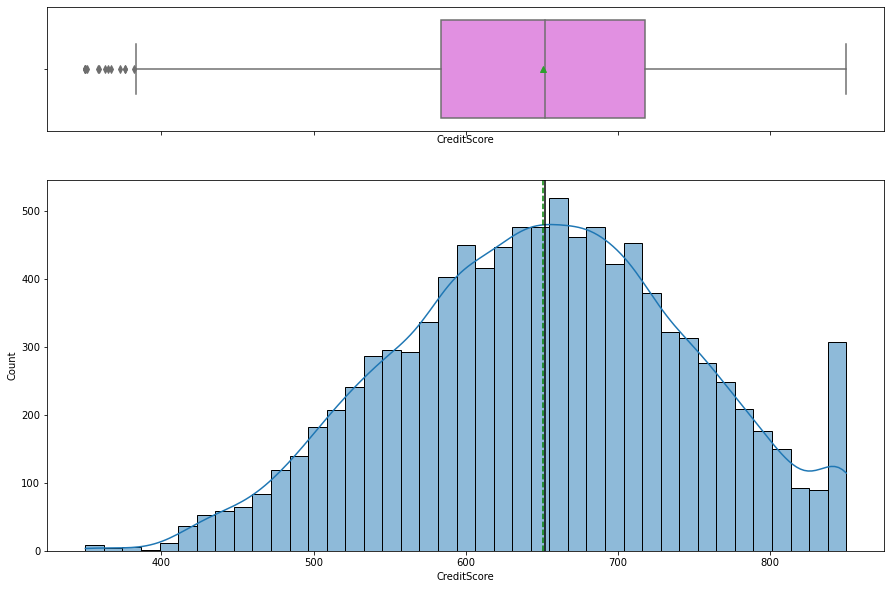

In [14]:
histogram_boxplot(working_df.CreditScore)

In [15]:
px.box(working_df.CreditScore, orientation='h', height=200)

In [16]:
px.histogram(working_df.CreditScore)

In [17]:
working_df.CreditScore.describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: CreditScore, dtype: float64

* Mean and median are very close (650.5 and 652) - not significantly skewed
* However it has a few outliers on the left with vals 350-382 (lower fence of 383)
* Large no of values between 850-854 (233 rows)
* will treat outliers with standardisation/ normalisation

### 2.A (ii) Age

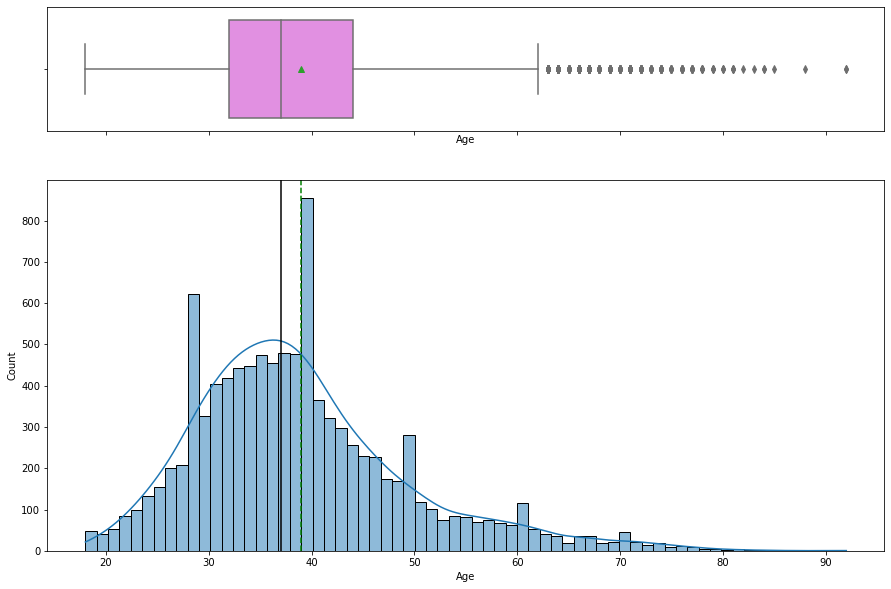

In [18]:
histogram_boxplot(working_df.Age)

In [19]:
px.box(working_df.Age, orientation='h', height=200)

In [20]:
print(f'No. of rows with age > 62: {working_df[working_df.Age>62].count()[1]}')

No. of rows with age > 62: 359


In [21]:
working_df.Age.describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

* Again mean is close to median so not significantly skewed
* outlier values beyond upper fence of 62 (63-92): 359 such values (3.59% of dataset so relatively small percentage of outliers)
* will treat with standardisation/ normalisation

### 2.A (iii) Estimated Salary

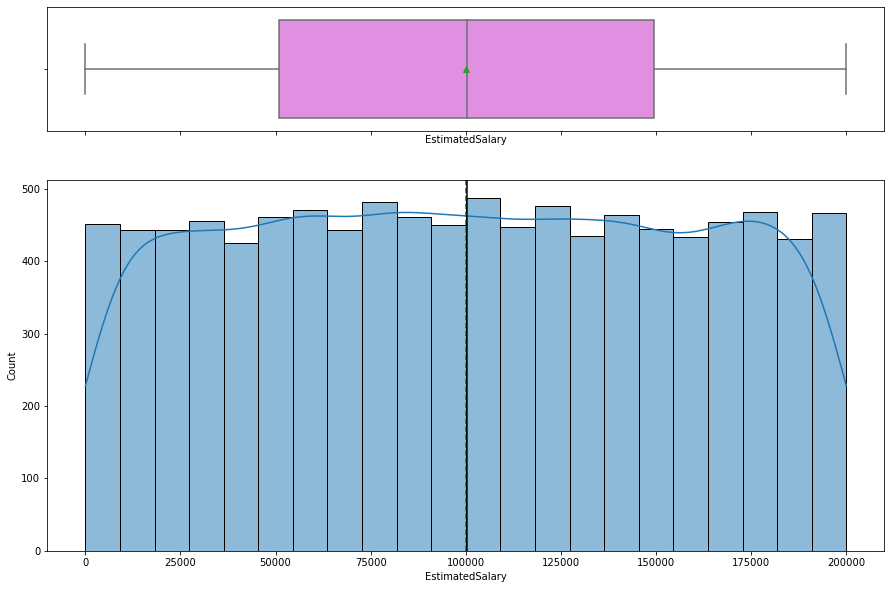

In [22]:
histogram_boxplot(working_df.EstimatedSalary)

In [23]:
px.box(working_df.EstimatedSalary,orientation='h',height=200)

In [24]:
working_df.EstimatedSalary.describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

 * Data is quite evenly distributed (mean ~= median)
 * No significant tails in this distribution which is interesting 
 * In any case will be normalised/ standardised - will use a method of scaling which preserves shape of distribution)

### 2.A (iv) Balance

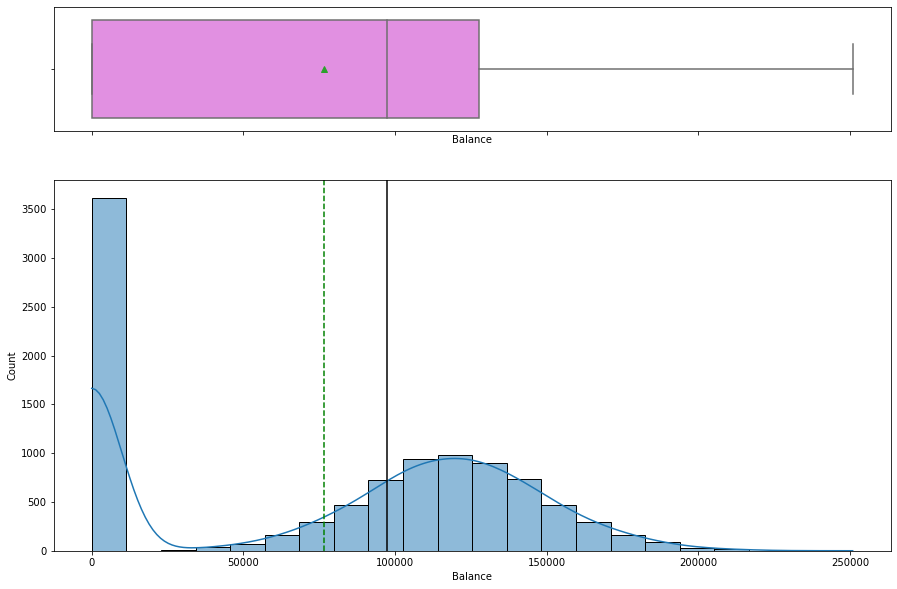

In [25]:
histogram_boxplot(working_df.Balance)

In [26]:
px.box(working_df.Balance, orientation='h', height=200)

In [27]:
#working_df[working_df.Balance == 0].count()
working_df.Balance.value_counts()

0.00         3617
105473.74       2
130170.82       2
72594.00        1
139723.90       1
             ... 
130306.49       1
92895.56        1
132005.77       1
166287.85       1
104001.38       1
Name: Balance, Length: 6382, dtype: int64

In [28]:
working_df.Balance.describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

* Data is left skewed (mean < median)
* In fact 3617 rows have 0 balance
* Will treat with standardisation/ normalisation


### 2.A (v) Tenure

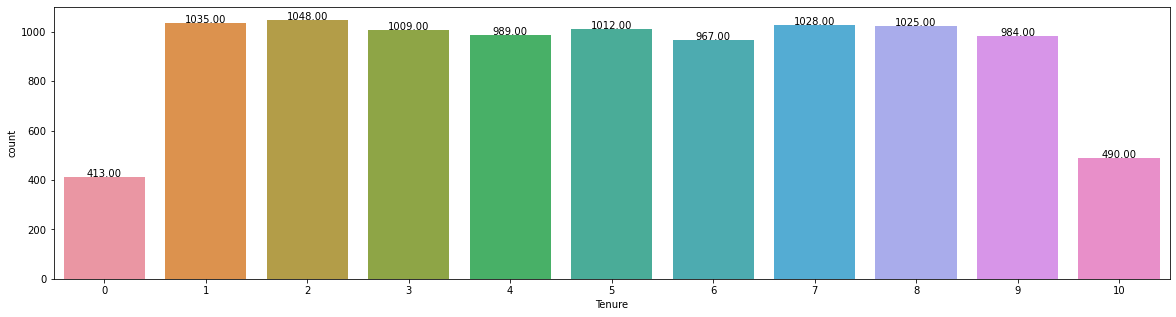

In [29]:
plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.Tenure)
show_values_on_bars(zz)

* Tenure is a categorical variable since it has only 11 unique values (0-10)
* However it is ordinal categorical so we leave it encoded as int
* Distribution is fairly symmetric

### 2.A (vi) NumOfProducts

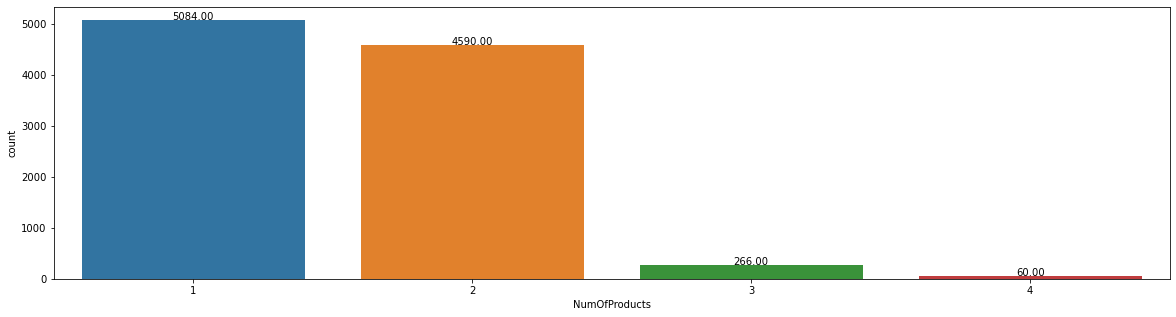

In [30]:
plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.NumOfProducts)
show_values_on_bars(zz)

* NumOfProducts is categorical - only 4 values
* Very few values for 3 and 4 - no material impact on model (in fact ran models with NumOfProducts=3 and 4 combined into one value but didnt affect model performance significantly)



### 2.A (vii) HasCrCard

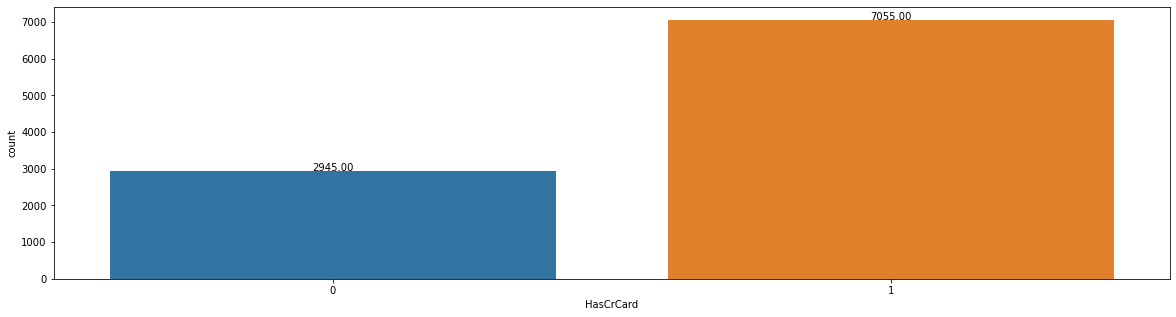

In [31]:
plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.HasCrCard)
show_values_on_bars(zz)

* 29.5% of rows dont have credit cards vs. 70.5% who do

### 2.A (viii) IsActiveMember

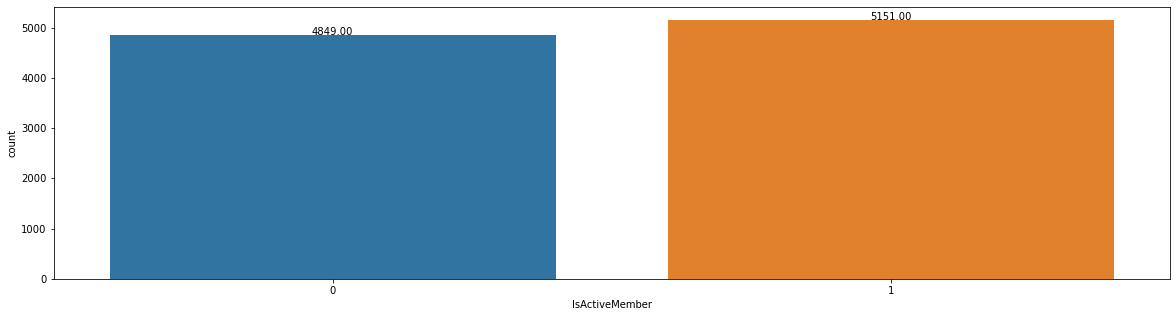

In [32]:

plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.IsActiveMember)
show_values_on_bars(zz)

* 48.5% of rows are not active members while 51.5% are

### 2.A (ix) Exited (Target Variable)

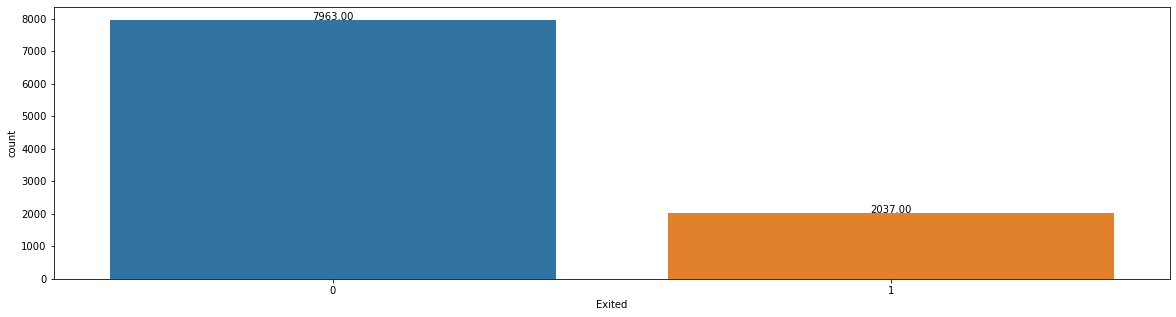

In [33]:
plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.Exited)
show_values_on_bars(zz)

* 79.6% of rows have not exited, while 20.4% have exited

### 2.A (x) Geography

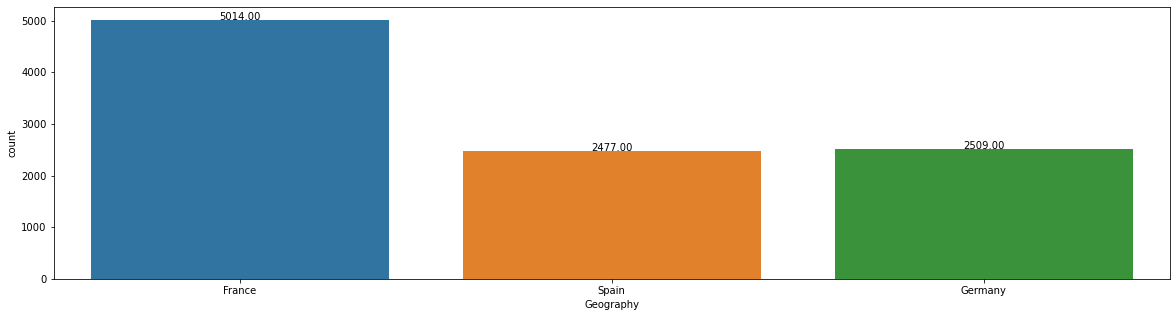

In [34]:
plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.Geography)
show_values_on_bars(zz)

* Most of the customers in the dataset are from France (50.1%) Germany and France are roughly equal at 25% each
* This column will need to be one hot encoded since it is object dtype

### 2.A (xi) Gender

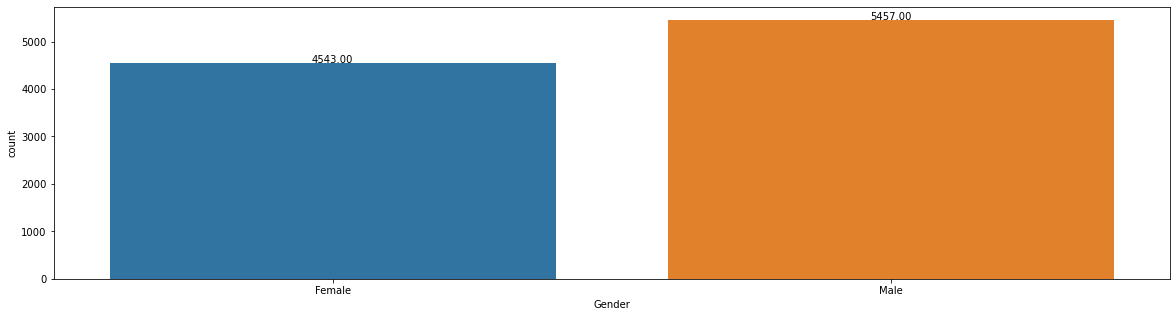

In [35]:
plt.figure(figsize=(20,5))
zz=sns.countplot(x=working_df.Gender)
show_values_on_bars(zz)

* 54.6% of the rows are Male and 45.4% are Female
* This column too will be one hot encoded

# 2.B Bivariate Analysis

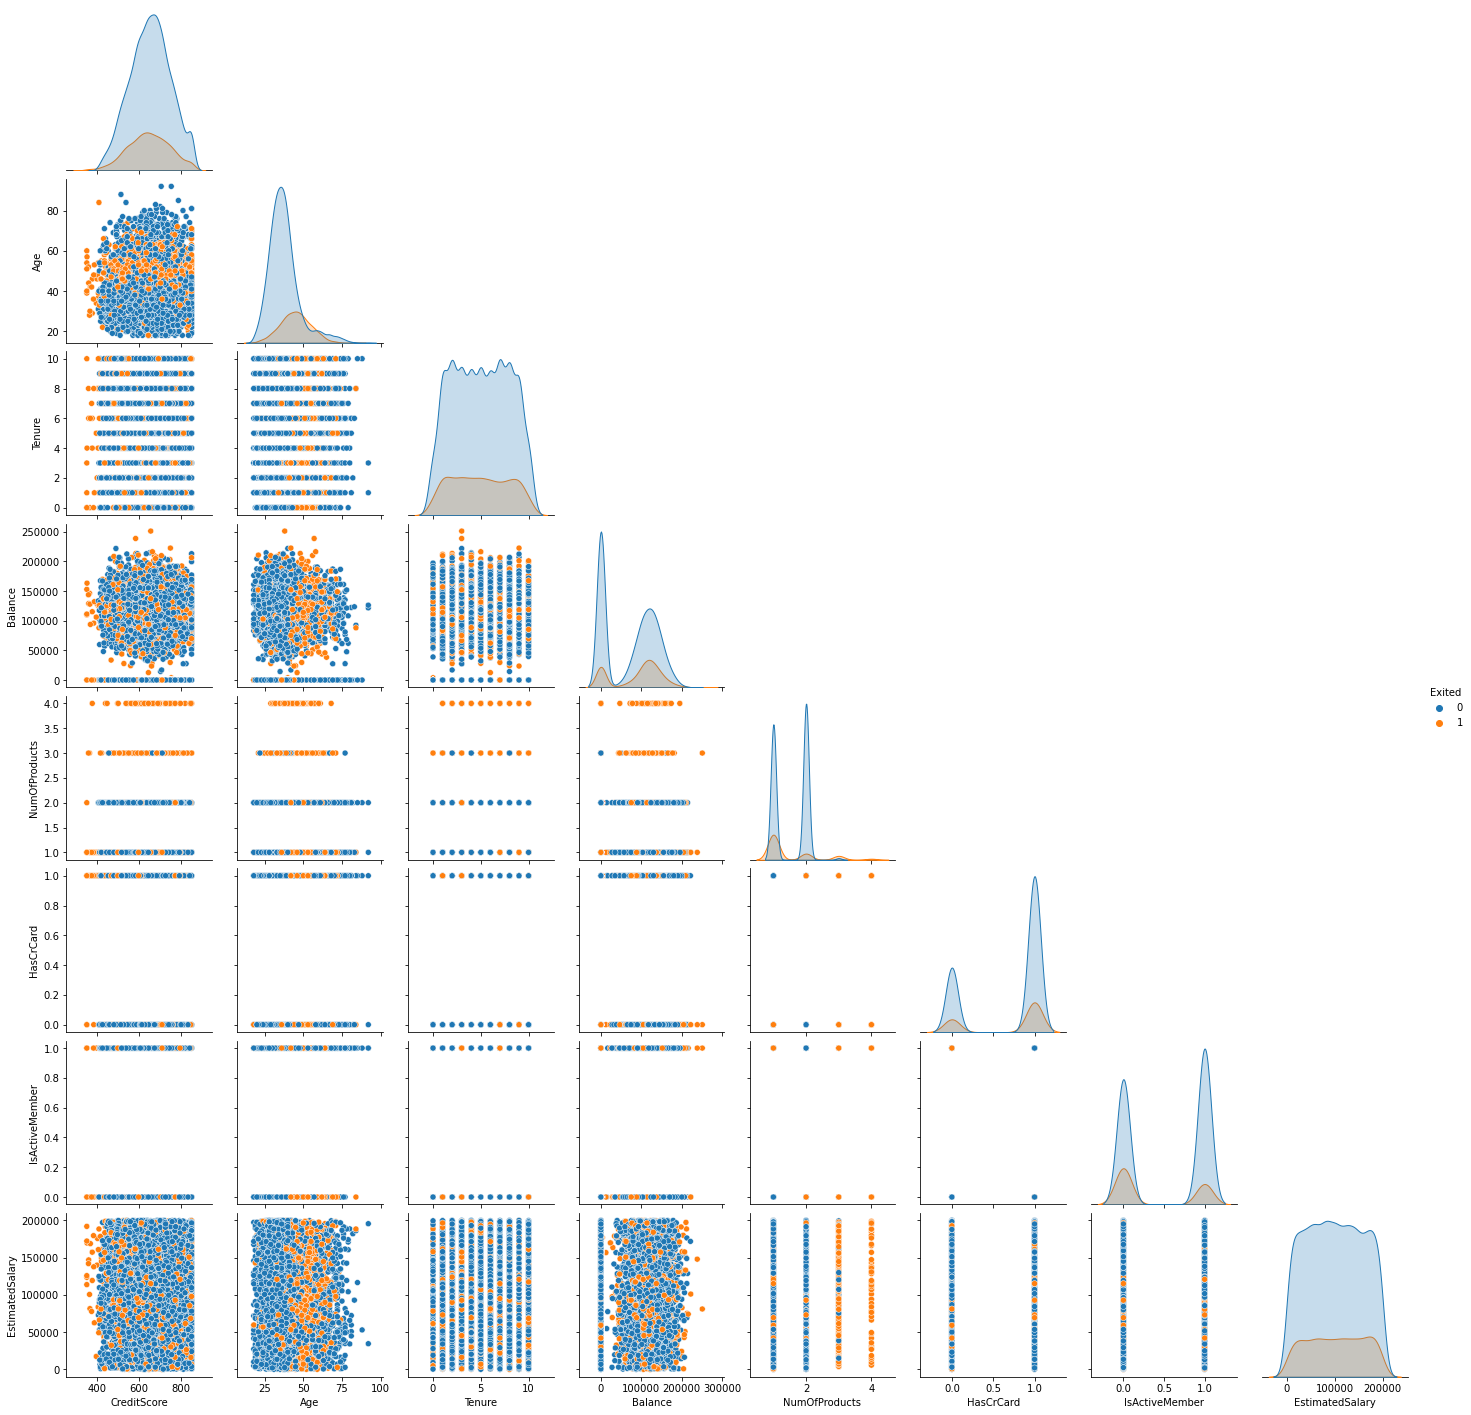

In [36]:
sns.pairplot(working_df,corner=True,diag_kind='kde', hue='Exited')

* Estimated salary varies quite widely even when balance = 0; these are prob dormant customers who use other banks' products
* Some patterns with Exited are evident for Age and NumOfProducts among others - shall explore further on


<AxesSubplot:>

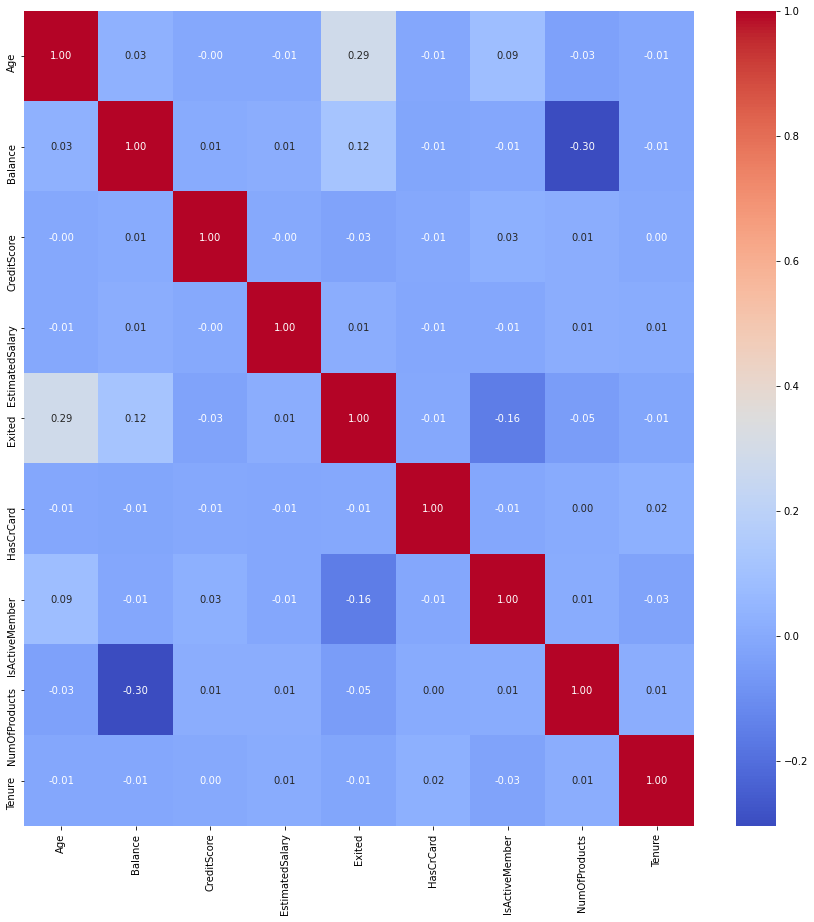

In [37]:
plt.figure(figsize=(15,15))
sns.heatmap(working_df.loc[:,numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')

* There aren't any significant correlations in the dataset evident from the above

### Examining bivariate relationships - vs. Exited

In [38]:
working_df.groupby('Exited').mean()

CreditScore        Age    Tenure       Balance  NumOfProducts  \
Exited                                                                  
0        651.853196  37.408389  5.033279  72745.296779       1.544267   
1        645.351497  44.837997  4.932744  91108.539337       1.475209   

        HasCrCard  IsActiveMember  EstimatedSalary  
Exited                                              
0        0.707146        0.554565     99738.391772  
1        0.699067        0.360825    101465.677531

In [39]:
working_df.groupby('Exited').median()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
Exited                                                                  
0               653   36       5   92072.68              2          1   
1               646   45       5  109349.29              1          1   

        IsActiveMember  EstimatedSalary  
Exited                                   
0                    1         99645.04  
1                    0        102460.84

* Credit Score: small diff here, exited have avg score of 652 vs 645 for non exited customers
    * Meaning the bank is losing out on good quality people who have decent credit scores (since mean of overall df is 651)
* Age: Exited customers are younger (37 vs 45 mean for exited vs non exited)
* Balance: lower balance for exited customers (mean of 72.7 k vs 91.1 k for exited vs non exited)
* Num of Products: exited customers have more products (2 vs 1 median although mean is only 1.54 vs 1.48 difference)
* Exited customers are more likely to be active members
* Salary is slightly lower for exited customers (~100k vs ~102k )
* Tenure: no significant difference
* HasCrCard,ActiveMember: let's examine these below as it's binary and not meaningful to examine here

* of the Balance = 0 customers a larger majority (86%) have not exited - as opposed to 80% for the full dataset who have exited


In [40]:
crosstabs = []
for i,col in enumerate(categorical_cols[1:]):
    crosstabs.append(pd.crosstab(working_df.Exited, working_df[col], normalize='columns'))
    display(crosstabs[i])

Gender    Female      Male
Exited                    
0       0.749285  0.835441
1       0.250715  0.164559

Geography    France   Germany     Spain
Exited                                 
0          0.838452  0.675568  0.833266
1          0.161548  0.324432  0.166734

HasCrCard         0         1
Exited                       
0          0.791851  0.798157
1          0.208149  0.201843

IsActiveMember         0         1
Exited                            
0               0.731491  0.857309
1               0.268509  0.142691

NumOfProducts         1         2         3    4
Exited                                          
0              0.722856  0.924183  0.172932  0.0
1              0.277144  0.075817  0.827068  1.0

Tenure        0         1         2       3         4         5         6   \
Exited                                                                       
0       0.769976  0.775845  0.808206  0.7889  0.794742  0.793478  0.797311   
1       0.230024  0.224155  0.191794  0.2111  0.205258  0.206522  0.202689   

Tenure        7         8         9         10  
Exited                                          
0       0.827821  0.807805  0.783537  0.793878  
1       0.172179  0.192195  0.216463  0.206122

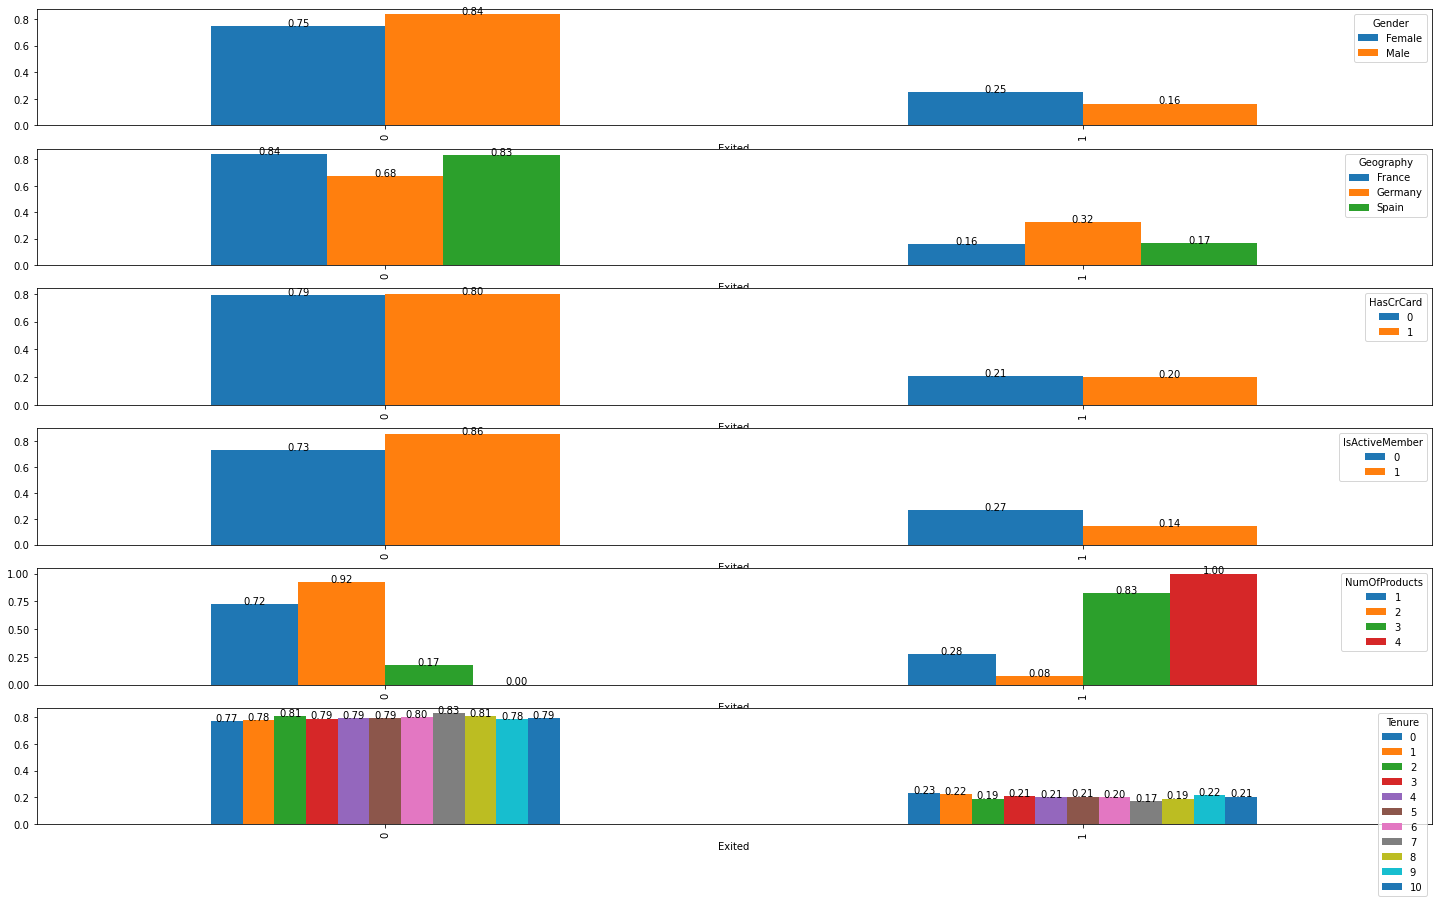

In [41]:
fig, axes = plt.subplots(6,1, figsize=(25,15))

for i,x in enumerate(crosstabs):
    zz=crosstabs[i].plot(kind='bar',ax=axes[i])
    show_values_on_bars(zz)

 * Gender: Men are less likely to have exited (83.5% of men vs. 74.9% of women have not exited)
 * Geography: German customers are more likely to exit vs French and Spanish (67.6% of Germans vs. ~83% of others have not Exited)
 * HasCrCard: Roughly equivalent 
 * IsActiveMember: Active members are less likely to have exited (86% of active members have not exited vs 73% of non active)
 * NumOfProducts: Customers with 2 products less likely to exit than those with 1 (92% vs 72%). Customers with 3 products likely to exit (only 17% didnt quit) and with 4 products all of the customers have exited.
    * However very few customers have 3 or 4 products so hard to draw a relation here
* Tenure: Quite an even spread here


### Bivariate vs. Balance

In [42]:
working_df[working_df.Balance==0].groupby('Exited').count().iloc[:,1]

Exited
0    3117
1     500
Name: Geography, dtype: int64

* 13.8% of balance=0 customers have exited

In [43]:
temp_df = working_df.copy()
temp_df['BalanceZero'] = temp_df.Balance.apply(lambda x: 1 if x ==0 else 0)

temp_df.groupby('BalanceZero').mean()


CreditScore        Age    Tenure        Balance  NumOfProducts  \
BalanceZero                                                                   
0             651.138493  39.197713  4.979633  119827.493793       1.386025   
1             649.452861  38.434891  5.071330       0.000000       1.784628   

             HasCrCard  IsActiveMember  EstimatedSalary    Exited  
BalanceZero                                                        
0             0.699201        0.513552    100717.352956  0.240796  
1             0.716616        0.517832     98983.559549  0.138236

* Interestingly, other than Exited which we discussed earlier, most other features are quite similar and do not vary much if Balance is or not zero
    * Customers who have no balance are less likely to exit (13.8% exited vs 20% in the full dataset)
* Perhaps these are dormant customers who therefore havent Exited since they don't engage much with the bank at all
    * They do have similar prob of owning credit cards similar to those with positive balance but it is not known if they are active on those cards
    * The credit score of balance =0 customers is similar to overall dataset (651) so these are quality customers who are probably not engaging enough with the bank

In [44]:
del(temp_df)

# 3. Data Preprocessing

In [45]:
# Form X and y
X = working_df.drop('Exited', axis=1)
y = working_df.Exited

#Convert categorical non numeric to one hot encoding
X = pd.get_dummies(X, drop_first=True)

#Define random_state for all algorithms that use this
random_state = 314159

X

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42       2       0.00              1          1   
1             608   41       1   83807.86              1          0   
2             502   42       8  159660.80              3          1   
3             699   39       1       0.00              2          0   
4             850   43       2  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39       5       0.00              2          1   
9996          516   35      10   57369.61              1          1   
9997          709   36       7       0.00              1          0   
9998          772   42       3   75075.31              2          1   
9999          792   28       4  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0                  1        101348.88                  0                0   
1                  1        112542.58                  0                1   
2                  0        113931.57                  0                0   
3                  0         93826.63                  0                0   
4                  1         79084.10                  0                1   
...              ...              ...                ...              ...   
9995               0         96270.64                  0                0   
9996               1        101699.77                  0                0   
9997               1         42085.58                  0                0   
9998               0         92888.52                  1                0   
9999               0         38190.78                  0                0   

      Gender_Male  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
9995            1  
9996            1  
9997            0  
9998            1  
9999            0  

[10000 rows x 11 columns]

* X has 10,000 rows and 11 columns (after one-hot and dropping first one-hot column)

* Target variable split of values as below:

In [46]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [47]:
# defined class weights dictionary per keras tutorial
neg, pos = np.bincount(working_df['Exited'])
total = neg + pos
print('class weights:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

class weights:
    Total: 10000
    Positive: 2037 (20.37% of total)



In [48]:
# define scaler
#https://stackoverflow.com/a/58850139 for ref on which scaler to use
scaler = RobustScaler(quantile_range=(25,75)) #using this as it retains shape of data distribution and also retains outliers 

#in any case RobustScaler yields better results than MinMax or Standard scalers

In [49]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=random_state)

In [50]:
X_test


CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
2441          735   29      10       0.00              2          1   
2786          511   40       9  124401.60              1          1   
2375          815   39       6       0.00              1          1   
3566          746   25       3  104833.79              1          0   
7616          610   27       4   87262.40              2          1   
...           ...  ...     ...        ...            ...        ...   
2513          666   39      10       0.00              2          1   
8474          721   33       4   72535.45              1          1   
4528          714   31       6  152926.60              1          1   
1732          735   49       5  121973.28              1          1   
5914          754   27       7  117578.35              2          0   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
2441               1         95025.27                  0                1   
2786               0        198814.24                  1                0   
2375               1         85167.88                  0                1   
3566               0         71911.30                  0                1   
7616               0        182720.07                  0                0   
...              ...              ...                ...              ...   
2513               0        102999.33                  0                0   
8474               1        103931.49                  0                1   
4528               1         50899.91                  0                1   
1732               0        148804.36                  0                0   
5914               1         87908.01                  1                0   

      Gender_Male  
2441            1  
2786            0  
2375            0  
3566            0  
7616            0  
...           ...  
2513            1  
8474            0  
4528            0  
1732            1  
5914            1  

[3000 rows x 11 columns]

In [51]:
# Checking that target split ratio maintained in train and test sets
print(f'% of +ve class in target in full dataset: {working_df[working_df.Exited==1].shape[0]/ working_df.shape[0]}')
print(f'% of +ve class in target in train: {y_train.value_counts()[1]/ len(y_train):0.4f}')
print(f'% of +ve class in target in test: {y_test.value_counts()[1]/ len(y_test):0.4f}')

% of +ve class in target in full dataset: 0.2037
% of +ve class in target in train: 0.2037
% of +ve class in target in test: 0.2037


In [52]:
# Scaling data
# To prevent test data leaking into train, we fit the scaler on train and then transform both train and test on that scaler

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)



print('Scaled X_train:')
display(X_train.describe().T)

print('\nScaled X_test:')
display(X_test.describe().T)


Scaled X_train:


count      mean       std       min       25%  \
CreditScore        7000.0 -0.011733  0.719086 -2.253731 -0.514925   
Age                7000.0  0.168060  0.881617 -1.583333 -0.416667   
Tenure             7000.0 -0.001743  0.578801 -1.000000 -0.600000   
Balance            7000.0 -0.164601  0.490244 -0.761774 -0.761774   
NumOfProducts      7000.0  0.526571  0.579087  0.000000  0.000000   
HasCrCard          7000.0 -0.293000  0.455171 -1.000000 -1.000000   
IsActiveMember     7000.0 -0.480714  0.499664 -1.000000 -1.000000   
EstimatedSalary    7000.0  0.001752  0.589707 -1.028401 -0.494425   
Geography_Germany  7000.0  0.251571  0.433947  0.000000  0.000000   
Geography_Spain    7000.0  0.251571  0.433947  0.000000  0.000000   
Gender_Male        7000.0 -0.455571  0.498058 -1.000000 -1.000000   

                            50%       75%       max  
CreditScore        0.000000e+00  0.485075  1.477612  
Age                0.000000e+00  0.583333  4.583333  
Tenure             0.000000e+00  0.400000  1.000000  
Balance           -5.722120e-17  0.238226  1.211395  
NumOfProducts      0.000000e+00  1.000000  3.000000  
HasCrCard          0.000000e+00  0.000000  0.000000  
IsActiveMember     0.000000e+00  0.000000  0.000000  
EstimatedSalary    7.470153e-17  0.505575  1.024988  
Geography_Germany  0.000000e+00  1.000000  1.000000  
Geography_Spain    0.000000e+00  1.000000  1.000000  
Gender_Male        0.000000e+00  0.000000  0.000000


Scaled X_test:


count      mean       std       min       25%       50%  \
CreditScore        3000.0 -0.009219  0.726535 -2.253731 -0.507463 -0.007463   
Age                3000.0  0.141694  0.855769 -1.583333 -0.416667  0.000000   
Tenure             3000.0  0.012600  0.577552 -1.000000 -0.400000  0.000000   
Balance            3000.0 -0.150121  0.491760 -0.761774 -0.761774  0.007951   
NumOfProducts      3000.0  0.538667  0.587611  0.000000  0.000000  0.000000   
HasCrCard          3000.0 -0.298000  0.457456 -1.000000 -1.000000  0.000000   
IsActiveMember     3000.0 -0.494667  0.500055 -1.000000 -1.000000  0.000000   
EstimatedSalary    3000.0 -0.006758  0.592448 -1.027595 -0.520785  0.002163   
Geography_Germany  3000.0  0.249333  0.432699  0.000000  0.000000  0.000000   
Geography_Spain    3000.0  0.238667  0.426340  0.000000  0.000000  0.000000   
Gender_Male        3000.0 -0.451333  0.497709 -1.000000 -1.000000  0.000000   

                        75%       max  
CreditScore        0.501866  1.477612  
Age                0.500000  4.583333  
Tenure             0.600000  1.000000  
Balance            0.250175  1.113007  
NumOfProducts      1.000000  3.000000  
HasCrCard          0.000000  0.000000  
IsActiveMember     0.000000  0.000000  
EstimatedSalary    0.504898  1.024338  
Geography_Germany  0.000000  1.000000  
Geography_Spain    0.000000  1.000000  
Gender_Male        0.000000  0.000000

* we see the dataset has been effectively scaled

# 4. Modelling

### Function and Constants needed for section

In [90]:
# Defining metrics - keras tutorial
# I retain these functions here to aid ready reference as needed to tune models
# Modified from source found at: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

THRESHOLD = 0.5 # threshold used to determine if output is 0 or 1 (since sigmoid outputs a continuous no between 0 and 1)

EPOCHS=100 # baseline epochs for model run

BATCH_SIZE=100 # baseline batchsize

#supress warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

#metrics for model to compute
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



#function to define and compile model
def make_model(metrics=METRICS, output_bias=None, dropout=False, learning_rate=1e-3, activation='relu'):
    if output_bias is not None:
        #print('bias being set')
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential()
  
    model.add(keras.layers.Dense(16, activation=activation,input_shape=(X_train.shape[-1],)))
    
    if dropout==True:
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

#variant of above
def make_model2(metrics=METRICS, output_bias=None, dropout=False, learning_rate=1e-3):
    if output_bias is not None:
        #print('bias being set')
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential()
  
    model.add(keras.layers.Dense(64, activation='relu',input_shape=(X_train.shape[-1],)))
    
    if dropout==True:
        model.add(keras.layers.Dropout(0.7))
    
    model.add(keras.layers.Dense(16, activation='relu'))
    
    if dropout==True:
        model.add(keras.layers.Dropout(0.6))

    
    model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

#function to plot model metrics (loss, accuracy, recall and precision)
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()



### 4.A Base model - only one hidden layer and few nodes

In [54]:
%%time
model1 = make_model()
#start with 100 epochs
history1 = model1.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, use_multiprocessing=True, validation_split=0.2)

Epoch 1/100
56/56 [==============================] - 2s 13ms/step - loss: 0.6336 - tp: 127.6140 - fp: 469.5965 - tn: 1844.5263 - fn: 456.5088 - accuracy: 0.6479 - precision: 0.2054 - recall: 0.2341 - auc: 0.4712 - prc: 0.2679 - val_loss: 0.5802 - val_tp: 24.0000 - val_fp: 45.0000 - val_tn: 1038.0000 - val_fn: 293.0000 - val_accuracy: 0.7586 - val_precision: 0.3478 - val_recall: 0.0757 - val_auc: 0.4809 - val_prc: 0.2503
Epoch 2/100
56/56 [==============================] - 0s 1ms/step - loss: 0.5304 - tp: 47.6316 - fp: 44.6316 - tn: 2273.7544 - fn: 532.2281 - accuracy: 0.7993 - precision: 0.5217 - recall: 0.0870 - auc: 0.5393 - prc: 0.2914 - val_loss: 0.5439 - val_tp: 8.0000 - val_fp: 21.0000 - val_tn: 1062.0000 - val_fn: 309.0000 - val_accuracy: 0.7643 - val_precision: 0.2759 - val_recall: 0.0252 - val_auc: 0.5511 - val_prc: 0.2747
Epoch 3/100
56/56 [==============================] - 0s 2ms/step - loss: 0.4935 - tp: 22.2281 - fp: 27.3860 - tn: 2309.5088 - fn: 539.1228 - accuracy: 0.804

56/56 [==============================] - 0s 2ms/step - loss: 0.3838 - tp: 180.1579 - fp: 70.2105 - tn: 2259.1053 - fn: 388.7719 - accuracy: 0.8428 - precision: 0.7186 - recall: 0.3215 - auc: 0.8075 - prc: 0.5807 - val_loss: 0.4351 - val_tp: 87.0000 - val_fp: 42.0000 - val_tn: 1041.0000 - val_fn: 230.0000 - val_accuracy: 0.8057 - val_precision: 0.6744 - val_recall: 0.2744 - val_auc: 0.7886 - val_prc: 0.5698
Epoch 21/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3747 - tp: 198.3158 - fp: 69.0175 - tn: 2258.9649 - fn: 371.9474 - accuracy: 0.8510 - precision: 0.7532 - recall: 0.3572 - auc: 0.8200 - prc: 0.6056 - val_loss: 0.4322 - val_tp: 91.0000 - val_fp: 45.0000 - val_tn: 1038.0000 - val_fn: 226.0000 - val_accuracy: 0.8064 - val_precision: 0.6691 - val_recall: 0.2871 - val_auc: 0.7914 - val_prc: 0.5752
Epoch 22/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3870 - tp: 194.1930 - fp: 71.1754 - tn: 2250.9649 - fn: 381.9123 - accuracy: 0.8412 - preci

56/56 [==============================] - 0s 2ms/step - loss: 0.3559 - tp: 247.5614 - fp: 78.1053 - tn: 2242.1930 - fn: 330.3860 - accuracy: 0.8545 - precision: 0.7431 - recall: 0.4289 - auc: 0.8438 - prc: 0.6597 - val_loss: 0.3958 - val_tp: 124.0000 - val_fp: 39.0000 - val_tn: 1044.0000 - val_fn: 193.0000 - val_accuracy: 0.8343 - val_precision: 0.7607 - val_recall: 0.3912 - val_auc: 0.8326 - val_prc: 0.6565
Epoch 40/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3442 - tp: 249.8421 - fp: 72.1228 - tn: 2246.5789 - fn: 329.7018 - accuracy: 0.8596 - precision: 0.7717 - recall: 0.4237 - auc: 0.8580 - prc: 0.6770 - val_loss: 0.3933 - val_tp: 132.0000 - val_fp: 41.0000 - val_tn: 1042.0000 - val_fn: 185.0000 - val_accuracy: 0.8386 - val_precision: 0.7630 - val_recall: 0.4164 - val_auc: 0.8334 - val_prc: 0.6603
Epoch 41/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3338 - tp: 246.8421 - fp: 74.5965 - tn: 2255.7193 - fn: 321.0877 - accuracy: 0.8638 - pre

56/56 [==============================] - 0s 2ms/step - loss: 0.3313 - tp: 260.6667 - fp: 74.4211 - tn: 2243.1930 - fn: 319.9649 - accuracy: 0.8643 - precision: 0.7863 - recall: 0.4452 - auc: 0.8679 - prc: 0.6992 - val_loss: 0.3864 - val_tp: 136.0000 - val_fp: 39.0000 - val_tn: 1044.0000 - val_fn: 181.0000 - val_accuracy: 0.8429 - val_precision: 0.7771 - val_recall: 0.4290 - val_auc: 0.8412 - val_prc: 0.6771
Epoch 59/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3227 - tp: 271.6491 - fp: 69.6140 - tn: 2247.8246 - fn: 309.1579 - accuracy: 0.8732 - precision: 0.8185 - recall: 0.4753 - auc: 0.8742 - prc: 0.7208 - val_loss: 0.3849 - val_tp: 136.0000 - val_fp: 42.0000 - val_tn: 1041.0000 - val_fn: 181.0000 - val_accuracy: 0.8407 - val_precision: 0.7640 - val_recall: 0.4290 - val_auc: 0.8410 - val_prc: 0.6780
Epoch 60/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3266 - tp: 262.5789 - fp: 70.5789 - tn: 2254.7368 - fn: 310.3509 - accuracy: 0.8730 - pre

56/56 [==============================] - 0s 1ms/step - loss: 0.3202 - tp: 259.7719 - fp: 76.7895 - tn: 2259.1228 - fn: 302.5614 - accuracy: 0.8711 - precision: 0.7753 - recall: 0.4646 - auc: 0.8682 - prc: 0.7005 - val_loss: 0.3806 - val_tp: 141.0000 - val_fp: 50.0000 - val_tn: 1033.0000 - val_fn: 176.0000 - val_accuracy: 0.8386 - val_precision: 0.7382 - val_recall: 0.4448 - val_auc: 0.8437 - val_prc: 0.6828
Epoch 78/100
56/56 [==============================] - 0s 1ms/step - loss: 0.3300 - tp: 268.3860 - fp: 86.6491 - tn: 2236.0000 - fn: 307.2105 - accuracy: 0.8630 - precision: 0.7557 - recall: 0.4633 - auc: 0.8643 - prc: 0.7046 - val_loss: 0.3816 - val_tp: 138.0000 - val_fp: 45.0000 - val_tn: 1038.0000 - val_fn: 179.0000 - val_accuracy: 0.8400 - val_precision: 0.7541 - val_recall: 0.4353 - val_auc: 0.8436 - val_prc: 0.6829
Epoch 79/100
56/56 [==============================] - 0s 1ms/step - loss: 0.3208 - tp: 272.7544 - fp: 76.0175 - tn: 2245.4386 - fn: 304.0351 - accuracy: 0.8733 - pre

56/56 [==============================] - 0s 2ms/step - loss: 0.3237 - tp: 271.0351 - fp: 79.8772 - tn: 2243.9474 - fn: 303.3860 - accuracy: 0.8691 - precision: 0.7850 - recall: 0.4800 - auc: 0.8720 - prc: 0.7169 - val_loss: 0.3811 - val_tp: 135.0000 - val_fp: 46.0000 - val_tn: 1037.0000 - val_fn: 182.0000 - val_accuracy: 0.8371 - val_precision: 0.7459 - val_recall: 0.4259 - val_auc: 0.8460 - val_prc: 0.6856
Epoch 97/100
56/56 [==============================] - 0s 1ms/step - loss: 0.3155 - tp: 269.9649 - fp: 79.2982 - tn: 2250.9123 - fn: 298.0702 - accuracy: 0.8719 - precision: 0.7767 - recall: 0.4763 - auc: 0.8743 - prc: 0.7124 - val_loss: 0.3801 - val_tp: 136.0000 - val_fp: 48.0000 - val_tn: 1035.0000 - val_fn: 181.0000 - val_accuracy: 0.8364 - val_precision: 0.7391 - val_recall: 0.4290 - val_auc: 0.8453 - val_prc: 0.6856
Epoch 98/100
56/56 [==============================] - 0s 2ms/step - loss: 0.3236 - tp: 264.7193 - fp: 70.4737 - tn: 2257.7018 - fn: 305.3509 - accuracy: 0.8702 - pre

In [55]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


* Model has 209 parameters in total
* 1 hidden layer with 16 nodes and one output layer
    * The hidden layer uses relu activation function
* Output layer uses sigmoid

In [56]:
history_df = pd.DataFrame(history1.history)
history_df['epoch']=history1.epoch
display(history_df)
train_acc = history_df.loc[99,'accuracy']
train_recall = history_df.loc[99,'recall']
train_loss = history_df.loc[99,'loss']

loss     tp     fp      tn      fn  accuracy  precision    recall  \
0   0.596195  201.0  663.0  3828.0   908.0  0.719464   0.232639  0.181244   
1   0.520762   78.0   83.0  4408.0  1031.0  0.801071   0.484472  0.070334   
2   0.487728   41.0   54.0  4437.0  1068.0  0.799643   0.431579  0.036970   
3   0.465317   62.0   78.0  4413.0  1047.0  0.799107   0.442857  0.055906   
4   0.449409   93.0   89.0  4402.0  1016.0  0.802679   0.510989  0.083859   
..       ...    ...    ...     ...     ...       ...        ...       ...   
95  0.321874  516.0  149.0  4342.0   593.0  0.867500   0.775940  0.465284   
96  0.321986  527.0  160.0  4331.0   582.0  0.867500   0.767103  0.475203   
97  0.321585  513.0  143.0  4348.0   596.0  0.868036   0.782012  0.462579   
98  0.321287  515.0  140.0  4351.0   594.0  0.868929   0.786260  0.464382   
99  0.321058  531.0  156.0  4335.0   578.0  0.868929   0.772926  0.478810   

         auc       prc  ...  val_tp  val_fp  val_tn  val_fn  val_accuracy  \
0   0.482692  0.254282  ...    24.0    45.0  1038.0   293.0      0.758571   
1   0.545000  0.270261  ...     8.0    21.0  1062.0   309.0      0.764286   
2   0.625671  0.305788  ...    10.0    24.0  1059.0   307.0      0.763571   
3   0.695019  0.359460  ...    22.0    34.0  1049.0   295.0      0.765000   
4   0.729777  0.399000  ...    30.0    36.0  1047.0   287.0      0.769286   
..       ...       ...  ...     ...     ...     ...     ...           ...   
95  0.871937  0.709156  ...   135.0    46.0  1037.0   182.0      0.837143   
96  0.871822  0.709242  ...   136.0    48.0  1035.0   181.0      0.836429   
97  0.872021  0.710075  ...   134.0    49.0  1034.0   183.0      0.834286   
98  0.872737  0.710313  ...   139.0    50.0  1033.0   178.0      0.837143   
99  0.872557  0.710724  ...   136.0    50.0  1033.0   181.0      0.835000   

    val_precision  val_recall   val_auc   val_prc  epoch  
0        0.347826    0.075710  0.480901  0.250323      0  
1        0.275862    0.025237  0.551085  0.274663      1  
2        0.294118    0.031546  0.630322  0.320409      2  
3        0.392857    0.069401  0.684663  0.359158      3  
4        0.454545    0.094637  0.713792  0.392455      4  
..            ...         ...       ...       ...    ...  
95       0.745856    0.425867  0.846033  0.685592     95  
96       0.739130    0.429022  0.845267  0.685617     96  
97       0.732240    0.422713  0.845467  0.685714     97  
98       0.735450    0.438486  0.845601  0.686231     98  
99       0.731183    0.429022  0.846211  0.686295     99  

[100 rows x 21 columns]

* This df captures all the eopchs of the model on both train and validation metrics (since we ran the model with validation_split)
* The 99 row captures the final train and validation metrics and we examine test performance below

In [57]:
results1=model1.evaluate(X_test, y_test.values)
#print(model1.metrics_names)
#print(results1)

results_df = pd.DataFrame(results1, index=model1.metrics_names, columns=['model1'])

results_df

94/94 [==============================] - 1s 1ms/step - loss: 0.3468 - tp: 296.0000 - fp: 103.0000 - tn: 2286.0000 - fn: 315.0000 - accuracy: 0.8607 - precision: 0.7419 - recall: 0.4845 - auc: 0.8518 - prc: 0.6851


model1
loss          0.346845
tp          296.000000
fp          103.000000
tn         2286.000000
fn          315.000000
accuracy      0.860667
precision     0.741855
recall        0.484452
auc           0.851803
prc           0.685067

* Tp: true positive - exits correctly predicted as such (bottom right of confusion matrix below)
* fp: false positive - non exits in correctly predicted by model as exits (top right of confusion matrix)
* tn: true negative - non exits correctly predicted as such by model (top left of matrix)
* fn: false negative - exits incorrectly predicted by model as non exits (bottom left of matrix)
* auc: area under the curve
* prc: precision recall curve

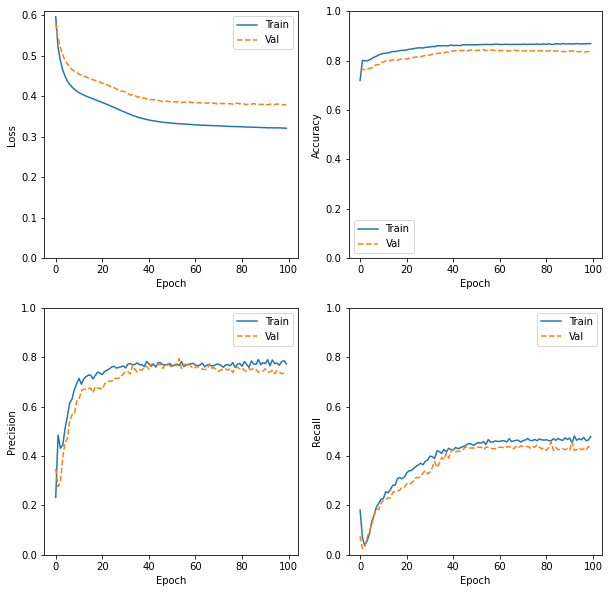

In [58]:
plt.figure(figsize=(10,10))
plot_metrics(history1)

* As we can see the model converges quite quickly and we could use fewer epochs - however it only takes a few seconds to run so we leave as is at 100 epochs

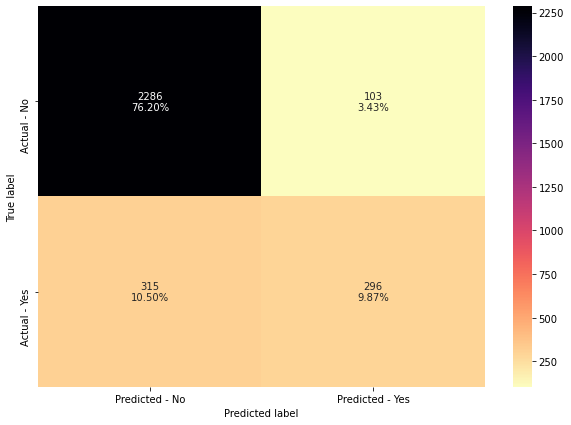

In [59]:

# ANN return continuous nos from 0 to 1 as output
# we use a threshold of 0.5 to classify the output as 0 or 1
# the code below converts the true/ false statement into 1/0 by forcing type conversion to int32


y_predict = (model1.predict(X_test) > THRESHOLD).astype('int32')

make_confusion_matrix(model1,y_test,y_predict, cmap='magma_r')


In [60]:
print(f'Model test loss is: {results_df.loc["loss","model1"]:0.4f}, train loss is {train_loss:0.4f}')
print(f'Model test accuracy is: {results_df.loc["accuracy","model1"]:0.4f}, train accuracy is {train_acc:0.4f}')
print(f'Model test recall is: {results_df.loc["recall","model1"]:0.4f}, train recall is {train_recall:0.4f}')

Model test loss is: 0.3468, train loss is 0.3211
Model test accuracy is: 0.8607, train accuracy is 0.8689
Model test recall is: 0.4845, train recall is 0.4788


* Model has not done that well - accuracy is decent but recall is poor 
    * looking at bottom left quadrant of the confusion matrix, we see many records which is a worry as we lose these customers to exits and couldn't predict they would exit
    * the top right quadrant are customers we predicted would exit but actually did not do so - given the specifics of this business problem this is a lower concern area (discussed in more detail at end of notebook)
    * The top left and bottom right are where our predictions align with reality (respectively - non exits predicted as non exits and exits predicted as exits)
    * No overfitting
* We will try to improve the model in the next section

### 4.B Refining the ANN Model - using class weights and more epochs

In [61]:
# Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data


# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


Weight for class 0: 0.63
Weight for class 1: 2.45


In [62]:
%%time 

model2 = make_model(dropout=True, learning_rate=0.001)

history2 = model2.fit(X_train, y_train, epochs=EPOCHS+100, batch_size=BATCH_SIZE, use_multiprocessing=True, validation_split=0.2, class_weight=class_weight, verbose=0) 
#setting verbose 0 to avoid cluttering the notebook

CPU times: user 29.5 s, sys: 4.28 s, total: 33.7 s
Wall time: 18.5 s


In [63]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                192       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 209
Trainable params: 209
Non-trainable params: 0
_________________________________________________________________


* Model has 209 parameters in total
* 1 hidden layer with 16 nodes and one output layer
    * The hidden layer uses relu activation function
* 1 droput layer to reduce overfitting
* Output layer uses sigmoid
* However this model uses class weights

In [64]:
history_df = pd.DataFrame(history2.history)
history_df['epoch']=history2.epoch
display(history_df)
train_acc = history_df.loc[199,'accuracy']
train_recall = history_df.loc[199,'recall']
train_loss = history_df.loc[199,'loss']

loss     tp      fp      tn      fn  accuracy  precision    recall  \
0    0.869449  351.0   201.0  6679.0  1369.0  0.817442   0.635870  0.204070   
1    0.797432  176.0   356.0  4135.0   933.0  0.769821   0.330827  0.158702   
2    0.743922  308.0   723.0  3768.0   801.0  0.727857   0.298739  0.277728   
3    0.709192  386.0   849.0  3642.0   723.0  0.719286   0.312551  0.348061   
4    0.674561  455.0  1039.0  3452.0   654.0  0.697679   0.304552  0.410280   
..        ...    ...     ...     ...     ...       ...        ...       ...   
195  0.499122  767.0   870.0  3621.0   342.0  0.783571   0.468540  0.691614   
196  0.509964  775.0   858.0  3633.0   334.0  0.787143   0.474587  0.698828   
197  0.501565  777.0   838.0  3653.0   332.0  0.791071   0.481115  0.700631   
198  0.504158  773.0   844.0  3647.0   336.0  0.789286   0.478046  0.697024   
199  0.510945  757.0   845.0  3646.0   352.0  0.786250   0.472534  0.682597   

          auc       prc  ...  val_tp  val_fp  val_tn  val_fn  val_accuracy  \
0    0.674824  0.433570  ...     0.0     0.0  1083.0   317.0      0.773571   
1    0.523980  0.256454  ...     2.0     1.0  1082.0   315.0      0.774286   
2    0.559720  0.268871  ...    33.0    28.0  1055.0   284.0      0.777143   
3    0.586016  0.306753  ...    81.0    96.0   987.0   236.0      0.762857   
4    0.630258  0.320323  ...   147.0   171.0   912.0   170.0      0.756429   
..        ...       ...  ...     ...     ...     ...     ...           ...   
195  0.833873  0.609528  ...   222.0   193.0   890.0    95.0      0.794286   
196  0.827193  0.586164  ...   220.0   194.0   889.0    97.0      0.792143   
197  0.833847  0.609951  ...   221.0   198.0   885.0    96.0      0.790000   
198  0.830421  0.604810  ...   220.0   198.0   885.0    97.0      0.789286   
199  0.826835  0.579900  ...   221.0   199.0   884.0    96.0      0.789286   

     val_precision  val_recall   val_auc   val_prc  epoch  
0         0.000000    0.000000  0.564945  0.293262      0  
1         0.666667    0.006309  0.622692  0.345243      1  
2         0.540984    0.104101  0.668993  0.377772      2  
3         0.457627    0.255520  0.706964  0.407480      3  
4         0.462264    0.463722  0.732552  0.424788      4  
..             ...         ...       ...       ...    ...  
195       0.534940    0.700315  0.848122  0.684006    195  
196       0.531401    0.694006  0.846244  0.680606    196  
197       0.527446    0.697161  0.846367  0.681103    197  
198       0.526316    0.694006  0.845655  0.678282    198  
199       0.526190    0.697161  0.845807  0.679480    199  

[200 rows x 21 columns]

* This df captures all the eopchs of the model on both train and validation metrics (since we ran the model with validation_split)
* The 199 row captures the final train and validation metrics and we examine test performance below

In [65]:
results_df = results_df['model1']

results2=model2.evaluate(X_test, y_test.values)

temp_df = pd.DataFrame(results2, index=model2.metrics_names, columns=['model2'])

results_df = pd.merge(results_df, temp_df, left_index=True, right_index=True)

results_df

94/94 [==============================] - 1s 1ms/step - loss: 0.4705 - tp: 440.0000 - fp: 452.0000 - tn: 1937.0000 - fn: 171.0000 - accuracy: 0.7923 - precision: 0.4933 - recall: 0.7201 - auc: 0.8495 - prc: 0.6703


model1       model2
loss          0.346845     0.470459
tp          296.000000   440.000000
fp          103.000000   452.000000
tn         2286.000000  1937.000000
fn          315.000000   171.000000
accuracy      0.860667     0.792333
precision     0.741855     0.493274
recall        0.484452     0.720131
auc           0.851803     0.849523
prc           0.685067     0.670289

* Explanations under similar table for model1

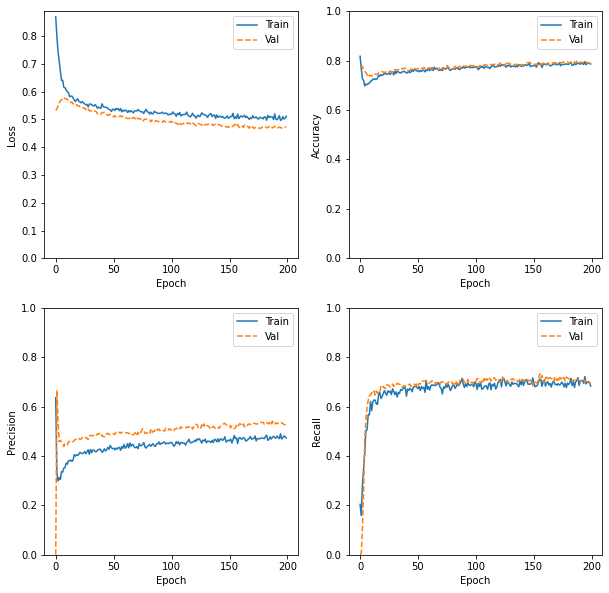

In [66]:
plt.figure(figsize=(10,10))
plot_metrics(history2)

* model converges around 100 epochs - I let it run for 200 as in some iterations recall doesnt converge neatly until about 150 or so

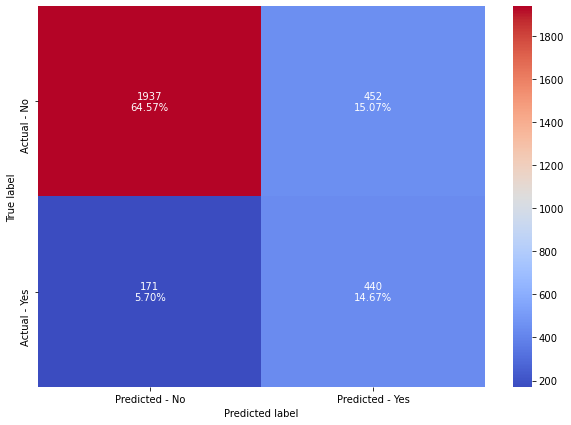

In [67]:
y_predict = (model2.predict(X_test) > THRESHOLD).astype('int32')
make_confusion_matrix(model2,y_test, y_predict, cmap='coolwarm')

In [68]:
print(f'Model test loss is: {results_df.loc["loss","model2"]:0.4f}, train loss is {train_loss:0.4f}')
print(f'Model test accuracy is: {results_df.loc["accuracy","model2"]:0.4f}, train accuracy is {train_acc:0.4f}')
print(f'Model test recall is: {results_df.loc["recall","model2"]:0.4f}, train recall is {train_recall:0.4f}')

Model test loss is: 0.4705, train loss is 0.5109
Model test accuracy is: 0.7923, train accuracy is 0.7862
Model test recall is: 0.7201, train recall is 0.6826



* much reduced false negative (bottom left of matrix) compared to model 1 at the cost of higher false positive (top right)
    * much more rows captured correctly as true positive (bottom right of matrix)
    * Slight overfitting on accuracy and recall
* Recall is much better than prev model but precision has fallen
    * This is at the cost of lower accuracy


### 4.C Using Tanh as activation for the hidden layers

In [69]:
%%time
model3 = make_model(dropout=True, learning_rate=0.001, activation='tanh')

history3 = model3.fit(X_train, y_train, epochs=EPOCHS+100, batch_size=BATCH_SIZE, use_multiprocessing=True, validation_split=0.2, class_weight=class_weight, verbose=0)

CPU times: user 27.8 s, sys: 4.26 s, total: 32 s
Wall time: 16.8 s


In [70]:
results_df = results_df.loc[:,['model1','model2']]

results3=model3.evaluate(X_test, y_test.values)

temp_df = pd.DataFrame(results3, index=model3.metrics_names, columns=['model2-tanh'])

results_df = pd.merge(results_df, temp_df, left_index=True, right_index=True)

results_df

94/94 [==============================] - 1s 1ms/step - loss: 0.4949 - tp: 433.0000 - fp: 522.0000 - tn: 1867.0000 - fn: 178.0000 - accuracy: 0.7667 - precision: 0.4534 - recall: 0.7087 - auc: 0.8243 - prc: 0.5848


model1       model2  model2-tanh
loss          0.346845     0.470459     0.494867
tp          296.000000   440.000000   433.000000
fp          103.000000   452.000000   522.000000
tn         2286.000000  1937.000000  1867.000000
fn          315.000000   171.000000   178.000000
accuracy      0.860667     0.792333     0.766667
precision     0.741855     0.493274     0.453403
recall        0.484452     0.720131     0.708674
auc           0.851803     0.849523     0.824308
prc           0.685067     0.670289     0.584837

In [71]:
print(f'Model test loss is: {results_df.loc["loss","model2-tanh"]:0.4f}')
print(f'Model test accuracy is: {results_df.loc["accuracy","model2-tanh"]:0.4f}')
print(f'Model test recall is: {results_df.loc["recall","model2-tanh"]:0.4f}')

Model test loss is: 0.4949
Model test accuracy is: 0.7667
Model test recall is: 0.7087


* Using tanh as hidden layer activation function worsened metrics such as accuracy and recall (in some iterations) and reduced AUC - not exploring this model any further

### 4.D Trying more complex model - 
* more hidden layers 
* more nodes 
* increasing batch size
* adjusted learning rate
* initial output bias being set per keras tutorial

In [95]:
%%time
model4 = make_model2(dropout=True, learning_rate=0.005, output_bias = np.log(pos/neg)) 

history4 = model4.fit(X_train, y_train, epochs=EPOCHS+100, batch_size=1000, use_multiprocessing=True, validation_split=0.2, class_weight=class_weight, verbose=0)
#setting verbose=0 to avoid cluttering the notebook

CPU times: user 14.4 s, sys: 4.57 s, total: 18.9 s
Wall time: 7.95 s


In [96]:
model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                768       
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________


* Model has 1825 parameters in total
* Layer 1: hidden layer with 64 nodes - uses relu activation
* Layer 2: dropout layer to reduce overfitting
* Layer 3: hidden layer with 16 nodes - uses relu activation
* Layer 4: dropout layer
* Output layer: uses sigmoid

In [97]:
history_df = pd.DataFrame(history4.history)
history_df['epoch']=history4.epoch
display(history_df)
train_acc = history_df.loc[199,'accuracy']
train_recall = history_df.loc[199,'recall']
train_loss = history_df.loc[199,'loss']

loss     tp      fp      tn      fn  accuracy  precision    recall  \
0    0.852494  577.0   845.0  6035.0  1143.0  0.768837   0.405767  0.335465   
1    0.734511  415.0  1198.0  3293.0   694.0  0.662143   0.257285  0.374211   
2    0.689148  518.0  1240.0  3251.0   591.0  0.673036   0.294653  0.467087   
3    0.668531  490.0   951.0  3540.0   619.0  0.719643   0.340042  0.441839   
4    0.653546  479.0   863.0  3628.0   630.0  0.733393   0.356930  0.431921   
..        ...    ...     ...     ...     ...       ...        ...       ...   
195  0.480674  812.0   812.0  3679.0   297.0  0.801964   0.500000  0.732191   
196  0.467797  833.0   840.0  3651.0   276.0  0.800714   0.497908  0.751127   
197  0.478710  807.0   783.0  3708.0   302.0  0.806250   0.507547  0.727683   
198  0.479745  778.0   781.0  3710.0   331.0  0.801429   0.499038  0.701533   
199  0.472510  804.0   788.0  3703.0   305.0  0.804821   0.505025  0.724977   

          auc       prc  ...  val_tp  val_fp  val_tn  val_fn  val_accuracy  \
0    0.641184  0.410032  ...     3.0     1.0  1082.0   314.0      0.775000   
1    0.570766  0.257065  ...   115.0   122.0   961.0   202.0      0.768571   
2    0.627775  0.307522  ...   106.0    94.0   989.0   211.0      0.782143   
3    0.651068  0.330337  ...   112.0    91.0   992.0   205.0      0.788571   
4    0.674920  0.355645  ...   119.0   118.0   965.0   198.0      0.774286   
..        ...       ...  ...     ...     ...     ...     ...           ...   
195  0.848983  0.646198  ...   222.0   175.0   908.0    95.0      0.807143   
196  0.858812  0.657732  ...   221.0   174.0   909.0    96.0      0.807143   
197  0.854230  0.633628  ...   219.0   171.0   912.0    98.0      0.807857   
198  0.851853  0.634848  ...   216.0   169.0   914.0   101.0      0.807143   
199  0.857057  0.646645  ...   221.0   175.0   908.0    96.0      0.806429   

     val_precision  val_recall   val_auc   val_prc  epoch  
0         0.750000    0.009464  0.663993  0.372692      0  
1         0.485232    0.362776  0.733171  0.418219      1  
2         0.530000    0.334385  0.751776  0.422954      2  
3         0.551724    0.353312  0.756898  0.424010      3  
4         0.502110    0.375394  0.758337  0.427406      4  
..             ...         ...       ...       ...    ...  
195       0.559194    0.700315  0.847312  0.688487    195  
196       0.559494    0.697161  0.846964  0.687874    196  
197       0.561538    0.690852  0.845197  0.684279    197  
198       0.561039    0.681388  0.846209  0.686232    198  
199       0.558081    0.697161  0.847946  0.689236    199  

[200 rows x 21 columns]

* This df captures all the eopchs of the model on both train and validation metrics (since we ran the model with validation_split)
* The 199 row captures the final train and validation metrics and we examine test performance below

In [98]:
results_df = results_df.loc[:,['model1','model2','model2-tanh']]

results4=model4.evaluate(X_test, y_test.values)

temp_df = pd.DataFrame(results4, index=model3.metrics_names, columns=['model4'])

results_df = pd.merge(results_df, temp_df, left_index=True, right_index=True)

results_df

94/94 [==============================] - 0s 914us/step - loss: 0.4398 - tp: 435.0000 - fp: 411.0000 - tn: 1978.0000 - fn: 176.0000 - accuracy: 0.8043 - precision: 0.5142 - recall: 0.7119 - auc: 0.8560 - prc: 0.6875


model1       model2  model2-tanh       model4
loss          0.346845     0.470459     0.494867     0.439847
tp          296.000000   440.000000   433.000000   435.000000
fp          103.000000   452.000000   522.000000   411.000000
tn         2286.000000  1937.000000  1867.000000  1978.000000
fn          315.000000   171.000000   178.000000   176.000000
accuracy      0.860667     0.792333     0.766667     0.804333
precision     0.741855     0.493274     0.453403     0.514184
recall        0.484452     0.720131     0.708674     0.711948
auc           0.851803     0.849523     0.824308     0.856039
prc           0.685067     0.670289     0.584837     0.687522

* Explanations under similar table for model1

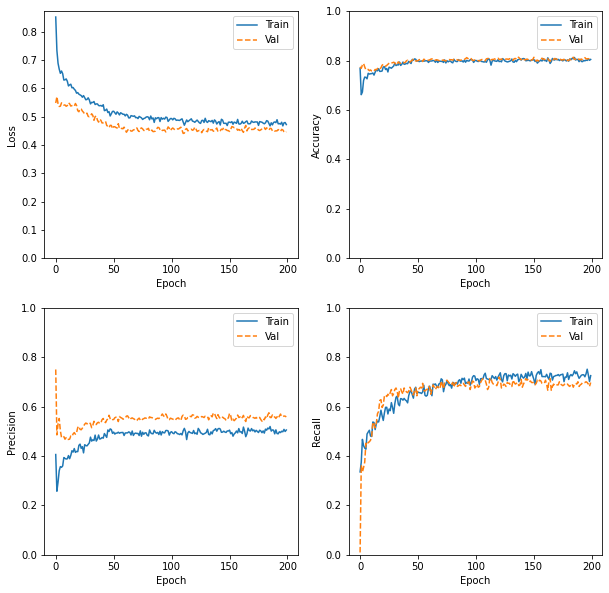

In [99]:
plt.figure(figsize=(10,10))
plot_metrics(history4)

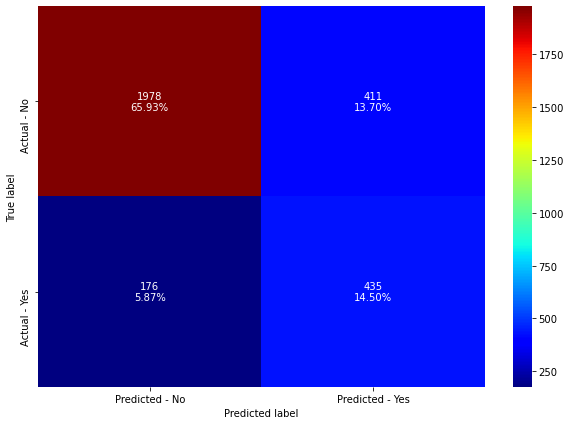

In [100]:
y_predict = (model4.predict(X_test) > THRESHOLD).astype('int32')
make_confusion_matrix(model4,y_test, y_predict, cmap='jet')

In [101]:
print(f'Model test loss is: {results_df.loc["loss","model4"]:0.4f}, train loss is {train_loss:0.4f}')
print(f'Model test accuracy is: {results_df.loc["accuracy","model4"]:0.4f}, train accuracy is {train_acc:0.4f}')
print(f'Model test recall is: {results_df.loc["recall","model4"]:0.4f}, train recall is {train_recall:0.4f}')

Model test loss is: 0.4398, train loss is 0.4725
Model test accuracy is: 0.8043, train accuracy is 0.8048
Model test recall is: 0.7119, train recall is 0.7250


In [102]:
f1=2*results_df.loc['recall']*results_df.loc['precision']/ (results_df.loc['recall']+results_df.loc['precision'])
print('f1 scores: \n')
pprint(f1)

f1 scores: 

model1         0.586139
model2         0.585496
model2-tanh    0.553001
model4         0.597117
dtype: float64



* Compared to model2, we catch more true positive
    * Not much overfitting on accuracy or recall
    * F1 score is the best of all models indicating a good balance between recall and precision
* Accuracy is lower than model 1 and 2 but we discuss the business implications below

# Final Conclusions and Business Recommendations

* Ultimately the choice of which model is chosen is a business decision
* Recall cannot be improved without sacrificing precision and also accuracy to some extent
* However for this use case, I believe Recall is the best metric to focus on -> the business needs to capture as many exit-risk customers as possible to target with an ad campaign or to make various promotion offers to keep them on as customers
    * If some customers are wrongly identified as exit risk (false positive), they will also be targetted with such ads or promotions but that should be a lower business cost than losing a customer
    * We still want to keep this number low to focus efforts on customers who are true exit risk
    * Main objective is reducing false negative while not allowing false positive to become too large

* Thus, I recommend model 4 which does a better job of balancing recall and precision than other models

* Additionally, the bank should examine Balance = 0 customers - if they are dormant, those customers may need some other form of incentivisation to use the banks's product. They may have lower likelihood of exiting but dormant customers are not adding value in any case
    * Given similar credit scores or balance = 0 vs not, I imagine these customers are more active with other banks

## Appendix: Using XGBoost to check ANN performance

In [80]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, make_scorer

#xgb.config_context()

In [81]:
params= {
        'n_estimators': np.arange(10,150,10),
        'scale_pos_weight': [(neg/pos)], 
        'learning_rate': [0.05,0.1,0.2,0.3], 
        'gamma': np.arange(0,150,10),
        'subsample': [0.5,0.6,0.7,0.8,0.9,1],
        'colsample_bytree': [0.1,0.2,0.3,0.5,0.7,1],
        'max_depth': [3,5,6,8,10,12,15],
        'tree_method': ['hist'], 
        'min_child_weight': [0,3,5,7,8,9,10],
        'colsample_bylevel': [0.5,0.7,1]
    }

In [82]:
%%time
modelx = XGBClassifier()
scorer = metrics.make_scorer(metrics.recall_score)
cvobj = RandomizedSearchCV(estimator=modelx, param_distributions=params, n_iter=50, \
                            scoring=scorer, cv=5, random_state=random_state)


cvobj.fit(X_train, y_train)

CPU times: user 7min 24s, sys: 22 s, total: 7min 46s
Wall time: 31.9 s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'gamma': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140]),
                                        '

In [83]:
cvobj.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=40, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=6,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3.9091801669121256,
              subsample=0.6, tree_method='hist', validate_parameters=1,
              verbosity=None)

In [84]:
yypred=cvobj.predict(X_test)

accuracy: 0.792, recall: 0.7430441898527005


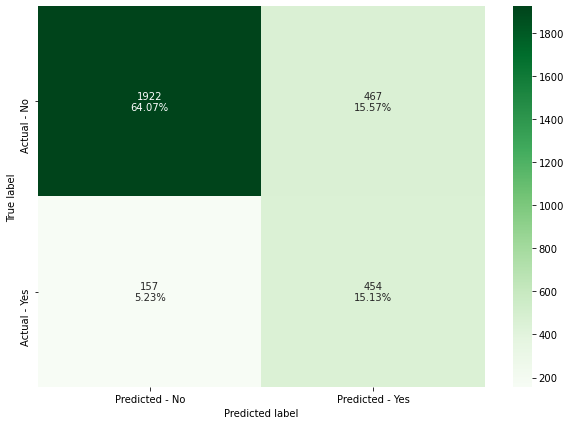

In [85]:


make_confusion_matrix(cvobj, y_test, cmap='Greens')

print(f'accuracy: {accuracy_score(y_test, yypred)}, recall: {recall_score(y_test, yypred)}')


* XGB performed similar to ANN